In [239]:
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# Gathering Data

In [240]:
mat = loadmat('20210201_run3_data.mat')
# this gives us a dictionary of arrays.. here are the values that we need to extract to look at
# crop to entries 11600:91200 (275s to 595s) in the Run3 file
# X- OXT_E
# Y- OXT_N
# yaw- OXT_aYaw
# Vx- OXT_vxCG
# Vy- OXT_vyCG
# yawrate- OXT_nYaw
# steer angle- CMD_aWheelFSteer (this is in degrees so * pi/180 to get radians) 
# accel request- CMD_gLongRequest (in g so *9.8 to get m/s)
# real ax- OXT_axCG
# real ay- OXT_ayCG

In [241]:
time = mat['Time'][:,0]
x = mat['OXT_E']
y = mat['OXT_N']
psi = mat['OXT_aYaw']
vx = mat['OXT_vxCG']
vy = mat['OXT_vyCG']
r = mat['OXT_nYaw']
steer = mat['CMD_aWheelFSteer'] # in degrees so * pi/180 to get radians
D = mat['CMD_gLongRequest'] # in g so *9.8 to get m/s
real_ax = mat['OXT_axCG']
real_ay = mat['OXT_ayCG']

In [242]:
# atime = 275.036 # start the data
atime = time[60000]
btime = 595

In [243]:
df = pd.DataFrame(x[(x[:,0] >= atime) & (x[:,0] <= btime)], columns=['time', 'x'])
df['x'] -= df['x'][0] # shift coordinate to start at 0
df['x'] *= -1
df['time'] -= df['time'][0]
data = [y, psi, vx, vy, r, steer, D, real_ax, real_ay]
labels = ['y', 'psi', 'vx', 'vy', 'r', 'steer', 'D', 'real_ax', 'real_ay']

for i in range(len(data)):
    label = labels[i] # get label
#     print(label)
    time_cut_data = data[i][(data[i][:,0] >= atime) & (data[i][:,0] <= btime)] # get 2d array in time frame
    if label in ('steer', 'D'):
        # we need to downsample
        time_cut_data = time_cut_data[::10]
        
    # manually check that they line up correctly
    # print(time_cut_data[:,0][:5])
    # print(time_cut_data[:,0][-5:])
    # print(time_cut_data.shape)
    
    values = time_cut_data[:,1] # now extract the actual column value
    
    if label == 'steer':
        # multiply pi/180 to get rad
        values *= math.pi / 180
    elif label == 'D':
        # multiple by 9.8 to get m/s^2
        values *= 9.8
    elif label == 'psi':
        values += math.pi * 1.12
    elif label == 'y':
        values -= values[0]

    
    df[labels[i]] = time_cut_data[:,1] # now extract the actual column value
    
df.to_csv('20210201_parsed_run3_data.csv')

In [233]:
df

,time,x,y,psi,vx,vy,r,steer,D,real_ax,real_ay
0,469.916,-0.000000,0.000000,2.521288,20.914034,0.033644,-0.01642,0.000719,-0.254461,-0.2095,0.2194
1,469.956,-0.689575,0.474304,2.520757,20.925581,0.040599,-0.01548,0.001095,-0.271038,0.3387,-0.4859
2,469.996,-1.379486,0.948502,2.520299,20.920303,0.033280,-0.01133,0.001457,-0.306820,-0.2400,-0.1717
3,470.036,-2.069550,1.422333,2.519940,20.923943,0.040129,0.00004,0.001808,-0.256734,0.3106,-0.4829
4,470.076,-2.759766,1.896225,2.519658,20.925726,0.038360,-0.00244,0.002118,-0.289739,-0.1916,-0.7657
...,...,...,...,...,...,...,...,...,...,...,...
3123,594.836,-139.352295,351.868683,0.924539,13.627166,0.029047,-0.02381,-0.002387,-4.272755,-5.6695,-0.0485
3124,594.876,-139.648666,351.414520,0.923508,13.422322,0.042470,-0.02686,-0.001995,-4.264626,-4.9157,0.0203
3125,594.916,-139.940216,350.967064,0.922436,13.224626,0.034855,-0.02117,-0.001501,-4.272468,-5.2175,-0.7925
3126,594.956,-140.226883,350.525917,0.921492,13.019039,0.037049,-0.01664,-0.001037,-4.236550,-5.6539,0.3684


# Plotting to Find Bug

In [59]:
# df['psi'] += math.pi/2

In [60]:
# df['psi'] = (df['psi'] + 2 * np.pi) % (2 * np.pi)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


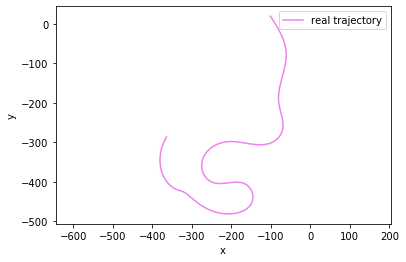

In [61]:
# x y coords
num_pts = 2000
# plt.plot(sol.y[0, :], sol.y[1, :], 'darkviolet', label='model output trajectory')
plt.plot(df['x'][:num_pts], df['y'][:num_pts], 'violet', label='real trajectory')
# plt.plot(data['x'], data['y'], 'violet', label='real trajectory')
plt.legend(loc='best')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

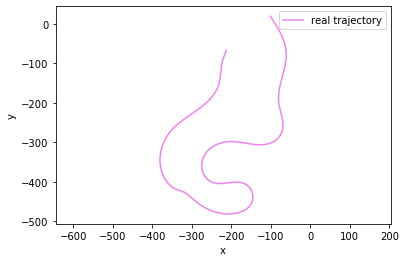

In [62]:
# x y coords
num_pts = 2500
# plt.plot(sol.y[0, :], sol.y[1, :], 'darkviolet', label='model output trajectory')
plt.plot(df['x'][:num_pts], df['y'][:num_pts], 'violet', label='real trajectory')
# plt.plot(data['x'], data['y'], 'violet', label='real trajectory')
plt.legend(loc='best')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

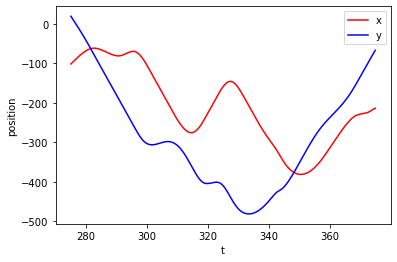

In [63]:
# x y coords
num_pts = 2500
# plt.plot(sol.y[0, :], sol.y[1, :], 'darkviolet', label='model output trajectory')
plt.plot(df['time'][:num_pts], df['x'][:num_pts], 'red', label='x')
plt.plot(df['time'][:num_pts], df['y'][:num_pts], 'blue', label='y')
# plt.plot(data['x'], data['y'], 'violet', label='real trajectory')
plt.legend(loc='best')
# plt.axis('equal')
plt.xlabel('t')
plt.ylabel('position')
plt.show()

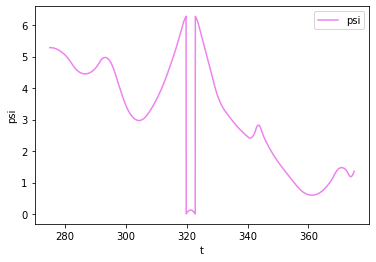

In [64]:
plt.plot(df['time'][:num_pts], df['psi'][:num_pts], 'violet', label='psi')
plt.legend(loc='best')
# plt.axis('equal')
plt.xlabel('t')
plt.ylabel('psi')
plt.show()